In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [73]:
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/bonds_us.pq')

In [74]:
data.reset_index(inplace=True)
yields = data.pivot(index='timestamp', columns='id', values='yield')

In [75]:
# Before proceeding we interpolate nans only if there is one consecutive

# Function to check single NaN in each column
def is_single_nan(series):
    mask = series.isna()
    # Single NaN is identified as a NaN surrounded by non-NaNs
    return mask & ~mask.shift(1, fill_value=False) & ~mask.shift(-1, fill_value=False)

print(f'previous NaNs: {yields.isna().sum().sum()}')
# Mask for single NaNs
single_nan_mask_yields = yields.apply(is_single_nan)

yields = yields.where(~single_nan_mask_yields, yields.interpolate(method='linear', limit=1, axis=0))
print(f'Current NaNs: {yields.isna().sum().sum()}')

previous NaNs: 6871482
Current NaNs: 6871044


<Axes: xlabel='timestamp'>

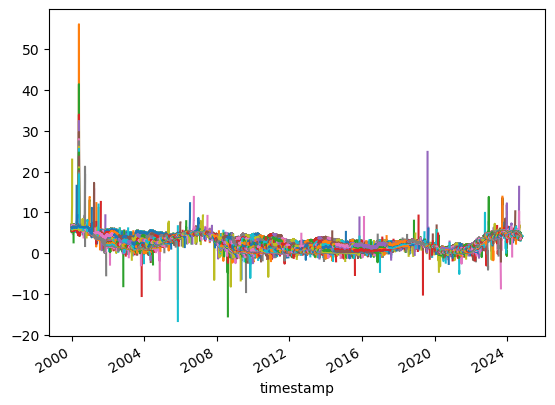

In [76]:
yields.plot(legend = False)

In [77]:
# Function to replace outliers with NaN using custom thresholds
def replace_outliers_with_nan(df, lower_threshold=-1, upper_threshold=12):
    numeric_data = df.select_dtypes(include=[np.number])
    return numeric_data.where((numeric_data >= lower_threshold) & (numeric_data <= upper_threshold), np.nan)

# Copy the dataset and mark only the outliers as NaN
yields = replace_outliers_with_nan(yields)

print(f'previous NaNs: {yields.isna().sum().sum()}')
# Mask for single nan
single_nan_mask_yields = yields.apply(is_single_nan)

yields = yields.where(~single_nan_mask_yields, yields.interpolate(method='linear', limit=3, axis=0))
print(f'Current NaNs: {yields.isna().sum().sum()}')

previous NaNs: 6871293
Current NaNs: 6871220


<Axes: xlabel='timestamp'>

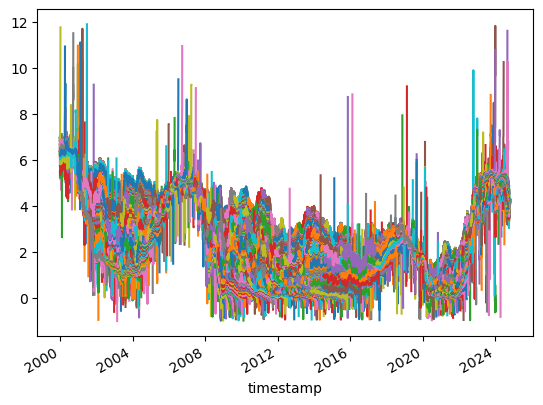

In [78]:
yields.plot(legend = False)

In [79]:
# Function to replace values that deviate by more than 3 standard deviations from the mean
def replace_deviations_with_nan(yields):
    for i in range(yields.shape[0]):
        row_mean = yields.iloc[i].mean()
        row_std = yields.iloc[i].std()
        # Replace values deviating more than 3 standard deviations with NaN
        yields.iloc[i] = yields.iloc[i].where(
            (yields.iloc[i] >= row_mean - 3 * row_std) & 
            (yields.iloc[i] <= row_mean + 3 * row_std),
            np.nan
        )
    return yields

# Apply the function to replace outliers with NaNs
yields = replace_deviations_with_nan(yields)

print(f'previous NaNs: {yields.isna().sum().sum()}')
# Mask for multiple Nan (limit = 3)
single_nan_mask_yields = yields.apply(is_single_nan)

yields = yields.where(~single_nan_mask_yields, yields.interpolate(method='linear', limit=3, axis=0))
print(f'current NaNs: {yields.isna().sum().sum()}')

previous NaNs: 6874804
current NaNs: 6874467


<Axes: xlabel='timestamp'>

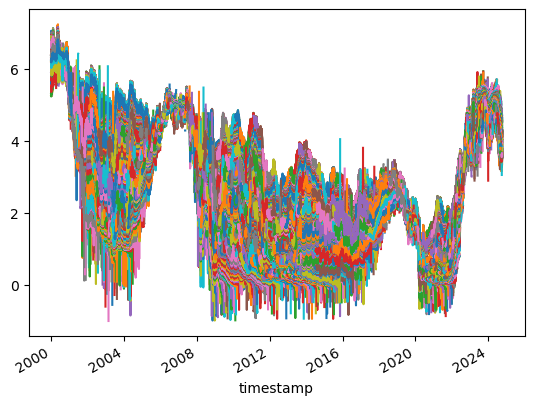

In [80]:
yields.plot(legend = False)

In [81]:
# Compute the mean number of bond outstanding for each trading day
outstanding = []
for i in range(yields.shape[0]):
    yields_dropna = yields.iloc[i].dropna()
    outstanding.append(len(yields_dropna))
np.mean(outstanding)

235.96172248803828

In [82]:
# Convert 'maturity' to datetime
data['maturity'] = pd.to_datetime(data['maturity'], errors='coerce')

# Drop rows where the 'maturity' is NaT (missing)
data = data.dropna(subset=['maturity'])

# Compute time to maturity
data.reset_index(inplace=True)
data['time to maturity'] = (data['maturity'] - data['timestamp']) / pd.Timedelta(days=365.25)

# Get time to maturities dataset
maturities = data.pivot(index='timestamp', columns='id', values='time to maturity')

# Mask single Nan for maturities
single_nan_mask_maturities = maturities.apply(is_single_nan)
maturities = maturities.where(~single_nan_mask_maturities, maturities.interpolate(method='linear', limit=1, axis=0))

In [85]:
# get average range of maturities for each date
maturities_range = []
for i in range(maturities.shape[0]):
    maturities_row = maturities.iloc[i].dropna()
    yields_row = yields.iloc[i].dropna()
    # Align indices of current_yields and current_maturities
    valid_indices = yields_row.index.intersection(maturities_row.index)
    current_yields = yields_row.loc[valid_indices]
    current_maturities = maturities_row.loc[valid_indices]
    maturity_range = np.max(current_maturities) - np.min(current_maturities)
    maturities_range.append(maturity_range)
np.mean(pd.Series(maturities_range).dropna())

29.32421564955595